In [65]:
# Load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.preprocessing import StandardScaler, LabelEncoder

from imblearn.over_sampling import SMOTE  # Import SMOTE for handling imbalanced data
import statsmodels.api as sm # to print statistical output
from scipy.stats import loguniform
from imblearn.pipeline import Pipeline as imba_Pipeline
from imblearn.pipeline import Pipeline
import statsmodels.api as sm


In [67]:
# Load your dataset (assuming 'crime.csv' file is available)
crime = pd.read_csv('clean_df_3_single_weapon.csv')
crime = pd.DataFrame(crime)
## age is still between 0 and 100

In [69]:
# target variable to convert to categorical
crime['Weapon Category'] = crime['Weapon Category'].astype('category')

# And update categ_features
categ_features = ['Region','Season','Victim Sex','Victim Ethnicity','Perpetrator Sex','Perpetrator Ethnicity','Relationship Category',
                  'Agency Type']


In [71]:
print(crime.isnull().sum())

Agency Type              0
Victim Sex               0
Victim Age               0
Victim Ethnicity         0
Perpetrator Sex          0
Perpetrator Ethnicity    0
Weapon Category          0
Relationship Category    0
Region                   0
Season                   0
dtype: int64


In [73]:
# 1. Apply get_dummies to all categorical features
# Use get_dummies for all categorical features except for Victim Sex, Perpetrator Sex, Victim Ethnicity, and Perpetrator Ethnicity
non_sex_ethnicity_features = [col for col in categ_features if col not in ['Victim Sex', 'Perpetrator Sex', 'Victim Ethnicity', 'Perpetrator Ethnicity']]
# the above code brings together all of the non-binary categories. 

# Apply get_dummies for these features
## The drop_first=True argument removes one category to avoid multicollinearity.
cr_non_sex_ethnicity = pd.get_dummies(crime[non_sex_ethnicity_features], drop_first=True) 
# the above requires that for all non-binary categories, get_dummies is applied

# 2. Apply get_dummies separately for 'Victim Sex' and 'Perpetrator Sex'
victim_sex_dummies = pd.get_dummies(crime['Victim Sex'], prefix='Victim Sex', drop_first=True)
perpetrator_sex_dummies = pd.get_dummies(crime['Perpetrator Sex'], prefix='Perpetrator Sex', drop_first=True)

# 3. Apply get_dummies separately for 'Victim Ethnicity' and 'Perpetrator Ethnicity'
victim_ethnicity_dummies = pd.get_dummies(crime['Victim Ethnicity'], prefix='Victim Ethnicity', drop_first=True)
perpetrator_ethnicity_dummies = pd.get_dummies(crime['Perpetrator Ethnicity'], prefix='Perpetrator Ethnicity', drop_first=True)

# 4. Concatenate all the dummy variable DataFrames
crime = pd.concat([crime, cr_non_sex_ethnicity, victim_sex_dummies, perpetrator_sex_dummies, victim_ethnicity_dummies, perpetrator_ethnicity_dummies], axis=1)

# 5. Drop the original categorical columns after applying get_dummies
#cr.drop(columns=['Victim Sex', 'Perpetrator Sex', 'Victim Ethnicity', 'Perpetrator Ethnicity', 'Season', 'Region', 'Relationship Category', 'Agency_Type_grouped'], inplace=True)

# Print the updated DataFrame to check
print(crime.head())

    Agency Type Victim Sex  Victim Age Victim Ethnicity Perpetrator Sex  \
0  Other Police     Female          26     Not Hispanic            Male   
1       Sheriff       Male          23     Not Hispanic            Male   
2       Sheriff       Male          42     Not Hispanic          Female   
3       Sheriff       Male          33     Not Hispanic            Male   
4       Sheriff       Male          46     Not Hispanic            Male   

  Perpetrator Ethnicity Weapon Category Relationship Category Region  Season  \
0          Not Hispanic     Non-Firearm                 Lover   West  Autumn   
1          Not Hispanic         Firearm          Acquaintance  South  Summer   
2          Not Hispanic         Firearm                 Lover  South  Summer   
3          Not Hispanic         Firearm          Acquaintance  South  Summer   
4          Not Hispanic         Firearm                Family  South  Autumn   

   ...  Season_Winter  Relationship Category_Family  \
0  ...       

In [75]:
# Prepare the model's feature data (X) and target variable (y)
X_dummy = crime.drop(columns=['Victim Sex', 'Perpetrator Sex', 'Victim Ethnicity', 'Perpetrator Ethnicity', 'Season', 'Region', 
                              'Relationship Category', 'Agency Type','Season_Spring','Season_Summer','Season_Winter','Victim Age', 
                              'Weapon Category'])
y_dummy = crime['Weapon Category']


In [77]:
# Changing categorical variables from X_dummy to integers
print(X_dummy.dtypes)
bool_columns = X_dummy.select_dtypes(include=['bool']).columns
print(bool_columns)
X_dummy[bool_columns] = X_dummy[bool_columns].astype(int)
print(X_dummy)

Region_Northeast                      bool
Region_South                          bool
Region_West                           bool
Relationship Category_Family          bool
Relationship Category_Lover           bool
Relationship Category_Stranger        bool
Agency Type_Other Police              bool
Agency Type_Sheriff                   bool
Victim Sex_Male                       bool
Perpetrator Sex_Male                  bool
Victim Ethnicity_Not Hispanic         bool
Perpetrator Ethnicity_Not Hispanic    bool
dtype: object
Index(['Region_Northeast', 'Region_South', 'Region_West',
       'Relationship Category_Family', 'Relationship Category_Lover',
       'Relationship Category_Stranger', 'Agency Type_Other Police',
       'Agency Type_Sheriff', 'Victim Sex_Male', 'Perpetrator Sex_Male',
       'Victim Ethnicity_Not Hispanic', 'Perpetrator Ethnicity_Not Hispanic'],
      dtype='object')
        Region_Northeast  Region_South  Region_West  \
0                      0             0      

In [79]:
# Create a scaler instance
scaler = StandardScaler()

# Scale the 'Victim Age' for model training
crime['Victim Age Scaled'] = scaler.fit_transform(crime[['Victim Age']])

In [83]:
# Combine dummy variables and 'Victim Age Scaled' into a new feature set (e.g., X_combined)
X_combined = pd.concat([X_dummy, crime[['Victim Age Scaled']]], axis=1)

# Verify the combined feature set
print(X_combined.head())


   Region_Northeast  Region_South  Region_West  Relationship Category_Family  \
0                 0             0            1                             0   
1                 0             1            0                             0   
2                 0             1            0                             0   
3                 0             1            0                             0   
4                 0             1            0                             1   

   Relationship Category_Lover  Relationship Category_Stranger  \
0                            1                               0   
1                            0                               0   
2                            1                               0   
3                            0                               0   
4                            0                               0   

   Agency Type_Other Police  Agency Type_Sheriff  Victim Sex_Male  \
0                         1                    0     

In [97]:
y_dummy

0         Non-Firearm
1             Firearm
2             Firearm
3             Firearm
4             Firearm
             ...     
153506        Firearm
153507        Firearm
153508        Firearm
153509        Firearm
153510    Non-Firearm
Name: Weapon Category, Length: 153511, dtype: category
Categories (2, object): ['Firearm', 'Non-Firearm']

In [99]:
y_dummy_numeric = y_dummy.map({'Firearm': 1, 'Non-Firearm': 0})

In [101]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_dummy_numeric, test_size=0.3, random_state=42, stratify=y_dummy_numeric)

# Apply SMOTE to the training data
#smote = SMOTE(random_state=42)  # Initialize SMOTE
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)  # Oversample the minority class



In [103]:
# Check for NaN values in the target variable
print(y_dummy_numeric.isnull().sum())


0


In [107]:
# Apply SMOTE to handle class imbalance
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution before and after SMOTE
print(f"Class distribution before SMOTE:\n{y_train.value_counts()}")
print(f"Class distribution after SMOTE:\n{y_train_resampled.value_counts()}")


Class distribution before SMOTE:
Weapon Category
1    72091
0    35366
Name: count, dtype: int64
Class distribution after SMOTE:
Weapon Category
1    72091
0    72091
Name: count, dtype: int64


In [117]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define the pipeline without SMOTE
pipeline = Pipeline([
    ("scaler", StandardScaler()),  # Only scaling in the pipeline
    ("log_reg", LogisticRegression(random_state=42, max_iter=1000))  # Logistic regression
])

# Define parameter grid for hyperparameter tuning
param_dist = {
    'log_reg__C': loguniform(1e-4, 1e4),  # Regularization strength for Logistic Regression
    'log_reg__solver': ['lbfgs', 'liblinear', 'saga'],  # Solvers to test for Logistic Regression
    'log_reg__max_iter': [1000, 2000, 3000],  # Maximum iterations for Logistic Regression
    'log_reg__penalty': ['l2', 'l1', None],  # Penalty types for Logistic Regression
    'log_reg__class_weight': ['balanced', None],  # Handle class imbalance for Logistic Regression
}


In [119]:
# Initialize SMOTE and apply it separately
smote = SMOTE(random_state=42)

# Apply SMOTE to resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    cv=5,  # Number of folds in cross-validation
    scoring="roc_auc",  # Use ROC AUC as the evaluation metric
    random_state=42,
    verbose=2,
    n_jobs=1  # Use all available CPUs
)

# Fit the model using the random search
random_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and score
print("Best Parameters: ", random_search.best_params_)
print("Best ROC AUC: ", random_search.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END log_reg__C=0.09915644566638401, log_reg__class_weight=balanced, log_reg__max_iter=3000, log_reg__penalty=None, log_reg__solver=lbfgs; total time=   0.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END log_reg__C=0.09915644566638401, log_reg__class_weight=balanced, log_reg__max_iter=3000, log_reg__penalty=None, log_reg__solver=lbfgs; total time=   0.2s
[CV] END log_reg__C=0.09915644566638401, log_reg__class_weight=balanced, log_reg__max_iter=3000, log_reg__penalty=None, log_reg__solver=lbfgs; total time=   0.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END log_reg__C=0.09915644566638401, log_reg__class_weight=balanced, log_reg__max_iter=3000, log_reg__penalty=None, log_reg__solver=lbfgs; total time=   0.2s
[CV] END log_reg__C=0.09915644566638401, log_reg__class_weight=balanced, log_reg__max_iter=3000, log_reg__penalty=None, log_reg__solver=lbfgs; total time=   0.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END log_reg__C=5.953896264004558, log_reg__class_weight=None, log_reg__max_iter=3000, log_reg__penalty=None, log_reg__solver=saga; total time=   0.9s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END log_reg__C=5.953896264004558, log_reg__class_weight=None, log_reg__max_iter=3000, log_reg__penalty=None, log_reg__solver=saga; total time=   0.9s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END log_reg__C=5.953896264004558, log_reg__class_weight=None, log_reg__max_iter=3000, log_reg__penalty=None, log_reg__solver=saga; total time=   0.8s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END log_reg__C=5.953896264004558, log_reg__class_weight=None, log_reg__max_iter=3000, log_reg__penalty=None, log_reg__solver=saga; total time=   0.8s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END log_reg__C=5.953896264004558, log_reg__class_weight=None, log_reg__max_iter=3000, log_reg__penalty=None, log_reg__solver=saga; total time=   0.8s
[CV] END log_reg__C=0.47205340620449887, log_reg__class_weight=balanced, log_reg__max_iter=3000, log_reg__penalty=l1, log_reg__solver=lbfgs; total time=   0.0s
[CV] END log_reg__C=0.47205340620449887, log_reg__class_weight=balanced, log_reg__max_iter=3000, log_reg__penalty=l1, log_reg__solver=lbfgs; total time=   0.0s
[CV] END log_reg__C=0.47205340620449887, log_reg__class_weight=balanced, log_reg__max_iter=3000, log_reg__penalty=l1, log_reg__solver=lbfgs; total time=   0.0s
[CV] END log_reg__C=0.47205340620449887, log_reg__class_weight=balanced, log_reg__max_iter=3000, log_reg__penalty=l1, log_reg__solver=lbfgs; total time=   0.0s
[CV] END log_reg__C=0.47205340620449887, log_reg__class_weight=balanced, log_reg__max_iter=3000, log_reg__penalty=l1, log_reg__solver=lbfgs; total time=   0.1s
[CV] END log_reg__C=5744.851636320435, log_re

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END log_reg__C=0.00011390176182186649, log_reg__class_weight=balanced, log_reg__max_iter=1000, log_reg__penalty=None, log_reg__solver=saga; total time=   0.9s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END log_reg__C=0.00011390176182186649, log_reg__class_weight=balanced, log_reg__max_iter=1000, log_reg__penalty=None, log_reg__solver=saga; total time=   0.9s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END log_reg__C=0.00011390176182186649, log_reg__class_weight=balanced, log_reg__max_iter=1000, log_reg__penalty=None, log_reg__solver=saga; total time=   0.8s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END log_reg__C=0.00011390176182186649, log_reg__class_weight=balanced, log_reg__max_iter=1000, log_reg__penalty=None, log_reg__solver=saga; total time=   0.9s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END log_reg__C=0.00011390176182186649, log_reg__class_weight=balanced, log_reg__max_iter=1000, log_reg__penalty=None, log_reg__solver=saga; total time=   0.9s
[CV] END log_reg__C=0.15808394808776696, log_reg__class_weight=None, log_reg__max_iter=3000, log_reg__penalty=l1, log_reg__solver=liblinear; total time=   0.4s
[CV] END log_reg__C=0.15808394808776696, log_reg__class_weight=None, log_reg__max_iter=3000, log_reg__penalty=l1, log_reg__solver=liblinear; total time=   0.3s
[CV] END log_reg__C=0.15808394808776696, log_reg__class_weight=None, log_reg__max_iter=3000, log_reg__penalty=l1, log_reg__solver=liblinear; total time=   0.4s
[CV] END log_reg__C=0.15808394808776696, log_reg__class_weight=None, log_reg__max_iter=3000, log_reg__penalty=l1, log_reg__solver=liblinear; total time=   0.4s
[CV] END log_reg__C=0.15808394808776696, log_reg__class_weight=None, log_reg__max_iter=3000, log_reg__penalty=l1, log_reg__solver=liblinear; total time=   0.4s
[CV] END log_reg__C=191.164696277843

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.f

Best Parameters:  {'log_reg__C': 0.15808394808776696, 'log_reg__class_weight': None, 'log_reg__max_iter': 3000, 'log_reg__penalty': 'l1', 'log_reg__solver': 'liblinear'}
Best ROC AUC:  0.6487401975950998


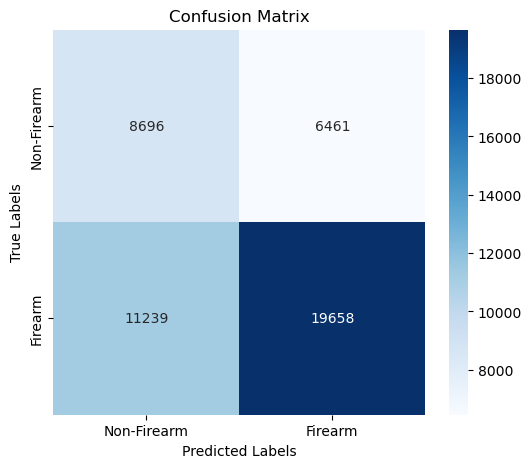


Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.57      0.50     15157
           1       0.75      0.64      0.69     30897

    accuracy                           0.62     46054
   macro avg       0.59      0.60      0.59     46054
weighted avg       0.65      0.62      0.63     46054

Accuracy: 0.6157
Precision: 0.7526
Recall: 0.6362
F1 Score: 0.6896
ROC AUC: 0.6484
Balanced Accuracy: 0.6050


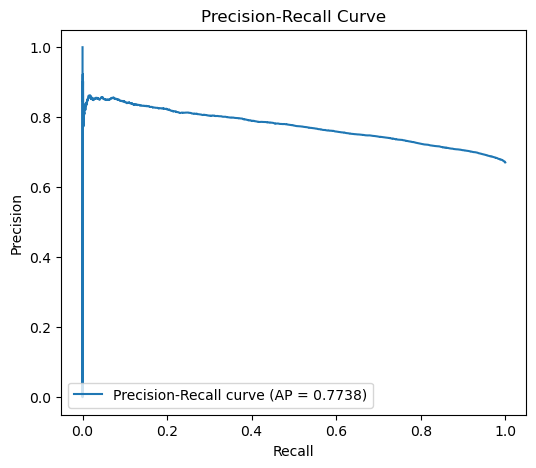

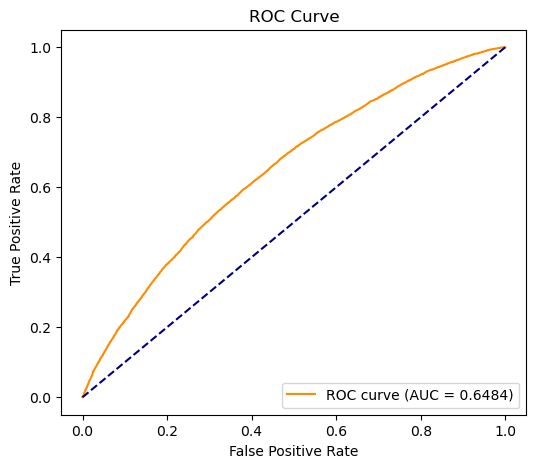

In [129]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score

# Generate predictions for the test set
y_pred = random_search.best_estimator_.predict(X_test)
y_pred_prob = random_search.best_estimator_.predict_proba(X_test)[:, 1]  # For ROC AUC and Precision-Recall

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
#print("Confusion Matrix:")
#print(cm)

# Visualize confusion matrix using heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Firearm', 'Firearm'], yticklabels=['Non-Firearm', 'Firearm'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

# Compute Precision-Recall curve and average precision score
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(6, 5))
plt.plot(recall_curve, precision_curve, label=f"Precision-Recall curve (AP = {average_precision:.4f})")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for random classifier
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


In [131]:
import statsmodels.api as sm
import pandas as pd

# Add a constant to the features for statsmodels
X_train_with_const = sm.add_constant(X_train_resampled)

# Fit the logistic regression model using statsmodels
log_reg_sm = sm.Logit(y_train_resampled, X_train_with_const)
result = log_reg_sm.fit()

# Print the summary report with F-statistic, t-statistics, p-values, etc.
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.657540
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:        Weapon Category   No. Observations:               144182
Model:                          Logit   Df Residuals:                   144168
Method:                           MLE   Df Model:                           13
Date:                Sun, 12 Jan 2025   Pseudo R-squ.:                 0.05137
Time:                        22:11:18   Log-Likelihood:                -94805.
converged:                       True   LL-Null:                       -99939.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -1.5950      0.034    